### Baseline

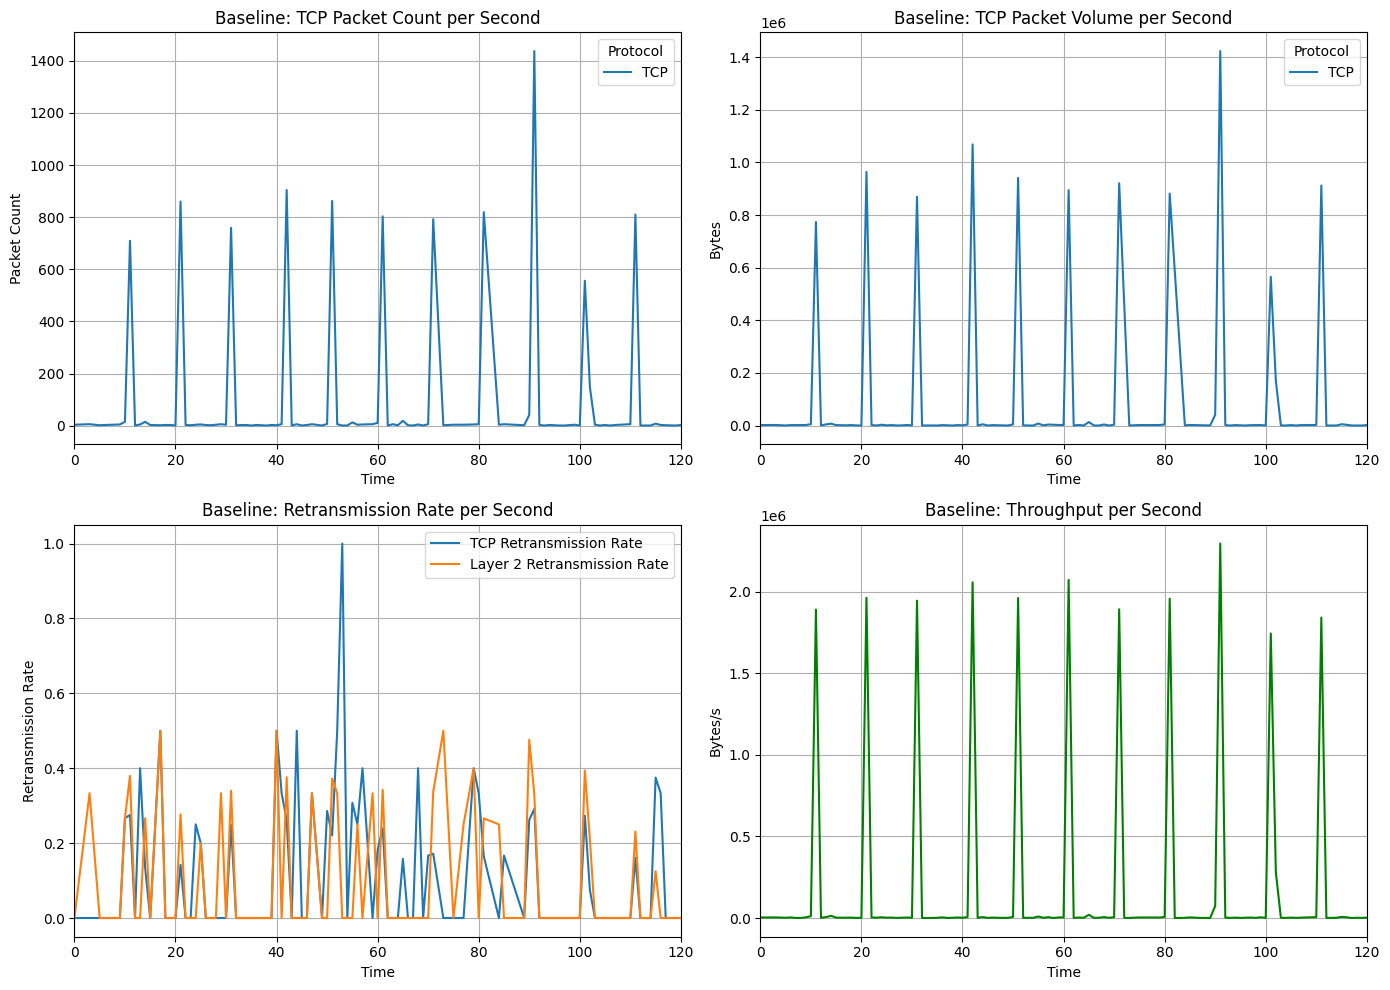

In [ ]:
#4.15
#Baseline: 31s

import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('../csvs/Baseline.csv')
tcp_retrans = pd.read_csv('../csvs/Baseline_tcp_retrans.csv')
layer2_retrans = pd.read_csv('../csvs/Baseline_layer2_retrans.csv')

# 预处理时间字段
for df in [data, tcp_retrans, layer2_retrans]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)

total_packet_counts_persecond = data.groupby('Time_bin').size()
# =========================
# 1. TCP & UDP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
# TCP
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / total_packet_counts_persecond.replace(0, pd.NA)).fillna(0)

# =========================
# 3. Throughput (all traffic)
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()

# =========================
# 4. 只保留31s到151s的数据，并重设x轴从0开始
# =========================
start, end = 31, 151
# 只取时间范围内的数据
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]

# 把时间bin映射成0~120
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start

# =========================
# 5. 绘图
# =========================
plt.figure(figsize=(14, 10))

# TCP/UDP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('Baseline: TCP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
packet_volumes.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('Baseline: TCP Packet Volume per Second')
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('Baseline: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Throughput
plt.subplot(2, 2, 4)
plt.plot(throughput.index, throughput.values, color='green')
plt.xlabel('Time')
plt.ylabel('Bytes/s')
plt.title('Baseline: Throughput per Second')
plt.grid(True)
plt.xlim(0, end - start)

plt.tight_layout()
plt.show()


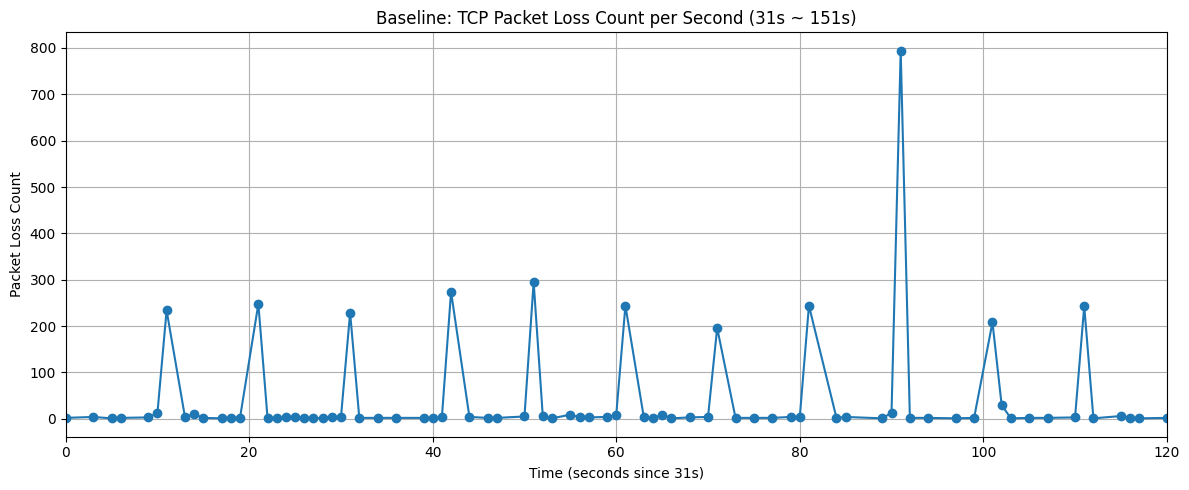

Total inferred TCP packet loss count (31s ~ 151s): 3445


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# 读取CSV
df = pd.read_csv('Baseline.csv')  # 修改成你的实际CSV文件名

# 提取 TCP Seq
def extract_seq(info):
    match = re.search(r'Seq=(\d+)', str(info))
    return int(match.group(1)) if match else None

# 预处理
df['Seq'] = df['Info'].apply(extract_seq)
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df.dropna(subset=['Seq', 'Time'], inplace=True)

# 保证只分析TCP包（如果有Protocol列）
if 'Protocol' in df.columns:
    df = df[df['Protocol'] == 'TCP']

# 按 Seq 升序 + Time 升序排序
df.sort_values(by=['Seq', 'Time'], inplace=True)

# 给每个 packet 添加发送次数编号（第一次发送是0，第二次发送是1，依此类推）
df['Seq_Send_Count'] = df.groupby('Seq').cumcount()

# 只保留 retransmission 包（即发送次数编号 > 0）
retransmissions = df[df['Seq_Send_Count'] > 0].copy()

# 把 retransmission 按 timestamp 秒数分组
retransmissions['Time_sec'] = retransmissions['Time'].astype(int)

# 只保留 31s 到 151s 的丢包数据
start, end = 31, 151
retransmissions = retransmissions[(retransmissions['Time_sec'] >= start) & (retransmissions['Time_sec'] <= end)]

# 重新映射时间：让31秒变成0秒
retransmissions['Time_mapped'] = retransmissions['Time_sec'] - start

# 每秒丢包数量
packet_loss_per_sec = retransmissions.groupby('Time_mapped').size()

# =========================
# 绘制每秒丢包数量
# =========================
plt.figure(figsize=(12, 5))
plt.plot(packet_loss_per_sec.index, packet_loss_per_sec.values, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Packet Loss Count')
plt.title('Baseline: TCP Packet Loss Count per Second')
plt.grid(True)
plt.xlim(0, end - start)
plt.tight_layout()
plt.show()

# =========================
# 打印总丢包数（在31~151s范围内）
# =========================
total_packet_loss = len(retransmissions)
print("Total inferred TCP packet loss count:", total_packet_loss)


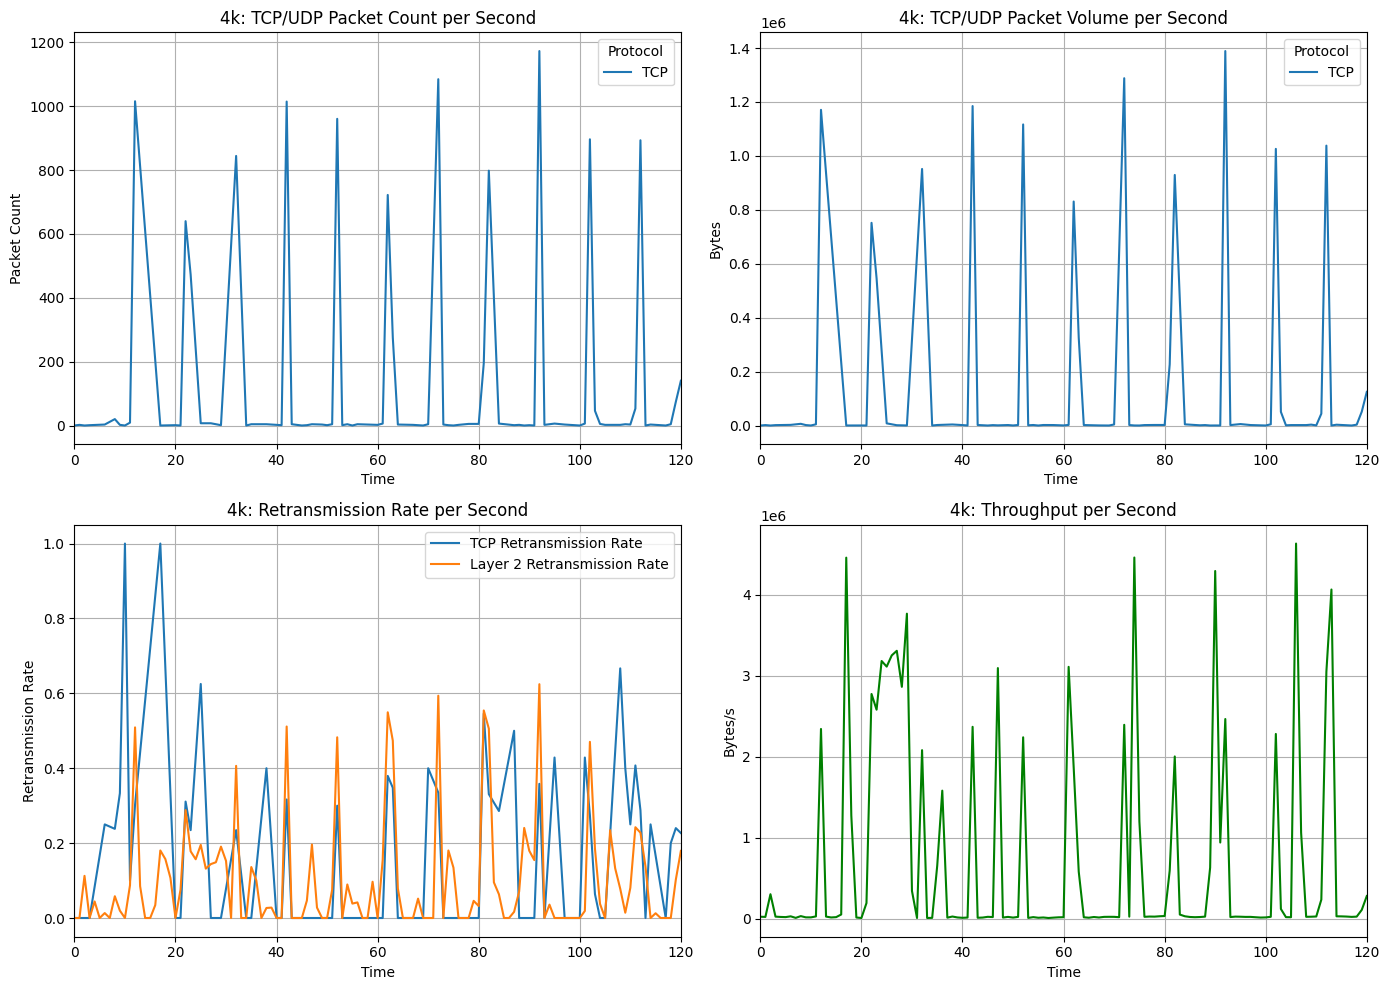

In [ ]:
#4.15
#4k: 29s

import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('4k.csv')
tcp_retrans = pd.read_csv('4k_tcp_retrans.csv')
layer2_retrans = pd.read_csv('4k_layer2_retrans.csv')

# 预处理时间字段
for df in [data, tcp_retrans, layer2_retrans]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)

# =========================
# 1. TCP & UDP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP', 'UDP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
# TCP
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / tcp_all_count.replace(0, pd.NA)).fillna(0)

# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == '802.11'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / layer2_all_count.replace(0, pd.NA)).fillna(0)

# =========================
# 3. Throughput (all traffic)
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()

# =========================
# 4. 只保留29s到149s的数据，并重设x轴从0开始
# =========================
start, end = 29, 149
# 只取时间范围内的数据
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]

# 把时间bin映射成0~120
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start

# =========================
# 5. 绘图
# =========================
plt.figure(figsize=(14, 10))

# TCP/UDP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('4k: TCP/UDP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
packet_volumes.plot(ax=plt.gca())
plt.xlabel('Time ')
plt.ylabel('Bytes')
plt.title('4k: TCP/UDP Packet Volume per Second')
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('4k: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Throughput
plt.subplot(2, 2, 4)
plt.plot(throughput.index, throughput.values, color='green')
plt.xlabel('Time')
plt.ylabel('Bytes/s')
plt.title('4k: Throughput per Second')
plt.grid(True)
plt.xlim(0, end - start)

plt.tight_layout()
plt.show()


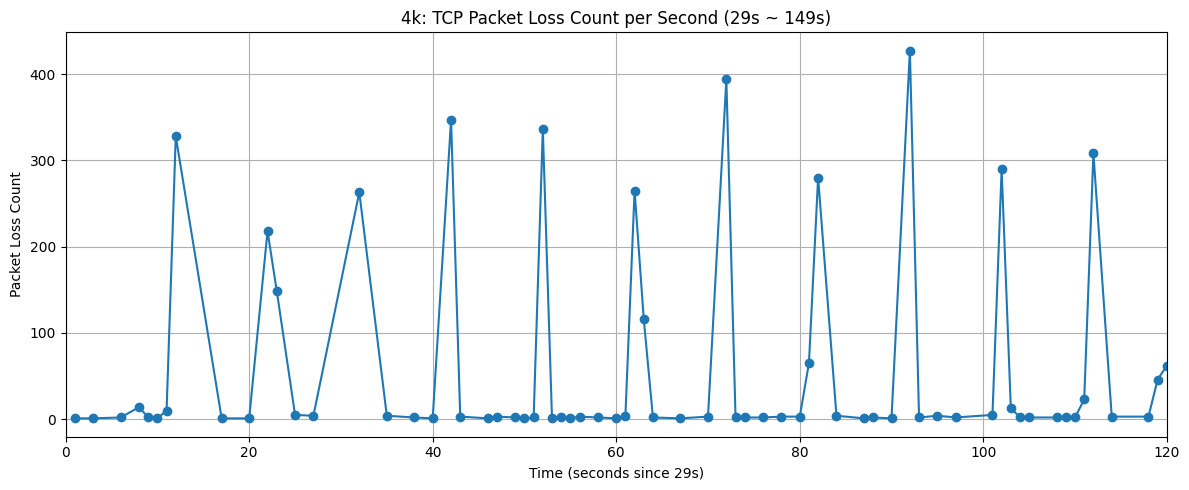

Total inferred TCP packet loss count (31s ~ 151s): 4063


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# 读取CSV
df = pd.read_csv('4k.csv')  # 修改成你的实际CSV文件名

# 提取 TCP Seq
def extract_seq(info):
    match = re.search(r'Seq=(\d+)', str(info))
    return int(match.group(1)) if match else None

# 预处理
df['Seq'] = df['Info'].apply(extract_seq)
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df.dropna(subset=['Seq', 'Time'], inplace=True)

# 保证只分析TCP包（如果有Protocol列）
if 'Protocol' in df.columns:
    df = df[df['Protocol'] == 'TCP']

# 按 Seq 升序 + Time 升序排序
df.sort_values(by=['Seq', 'Time'], inplace=True)

# 给每个 packet 添加发送次数编号（第一次发送是0，第二次发送是1，依此类推）
df['Seq_Send_Count'] = df.groupby('Seq').cumcount()

# 只保留 retransmission 包（即发送次数编号 > 0）
retransmissions = df[df['Seq_Send_Count'] > 0].copy()

# 把 retransmission 按 timestamp 秒数分组
retransmissions['Time_sec'] = retransmissions['Time'].astype(int)

# 只保留 31s 到 151s 的丢包数据
start, end = 29, 149
retransmissions = retransmissions[(retransmissions['Time_sec'] >= start) & (retransmissions['Time_sec'] <= end)]

# 重新映射时间：让31秒变成0秒
retransmissions['Time_mapped'] = retransmissions['Time_sec'] - start

# 每秒丢包数量
packet_loss_per_sec = retransmissions.groupby('Time_mapped').size()

# =========================
# 绘制每秒丢包数量
# =========================
plt.figure(figsize=(12, 5))
plt.plot(packet_loss_per_sec.index, packet_loss_per_sec.values, marker='o', linestyle='-')
plt.xlabel('Time (seconds since 29s)')
plt.ylabel('Packet Loss Count')
plt.title('4k: TCP Packet Loss Count per Second (29s ~ 149s)')
plt.grid(True)
plt.xlim(0, end - start)
plt.tight_layout()
plt.show()

# =========================
# 打印总丢包数（在31~151s范围内）
# =========================
total_packet_loss = len(retransmissions)
print("Total inferred TCP packet loss count (31s ~ 151s):", total_packet_loss)


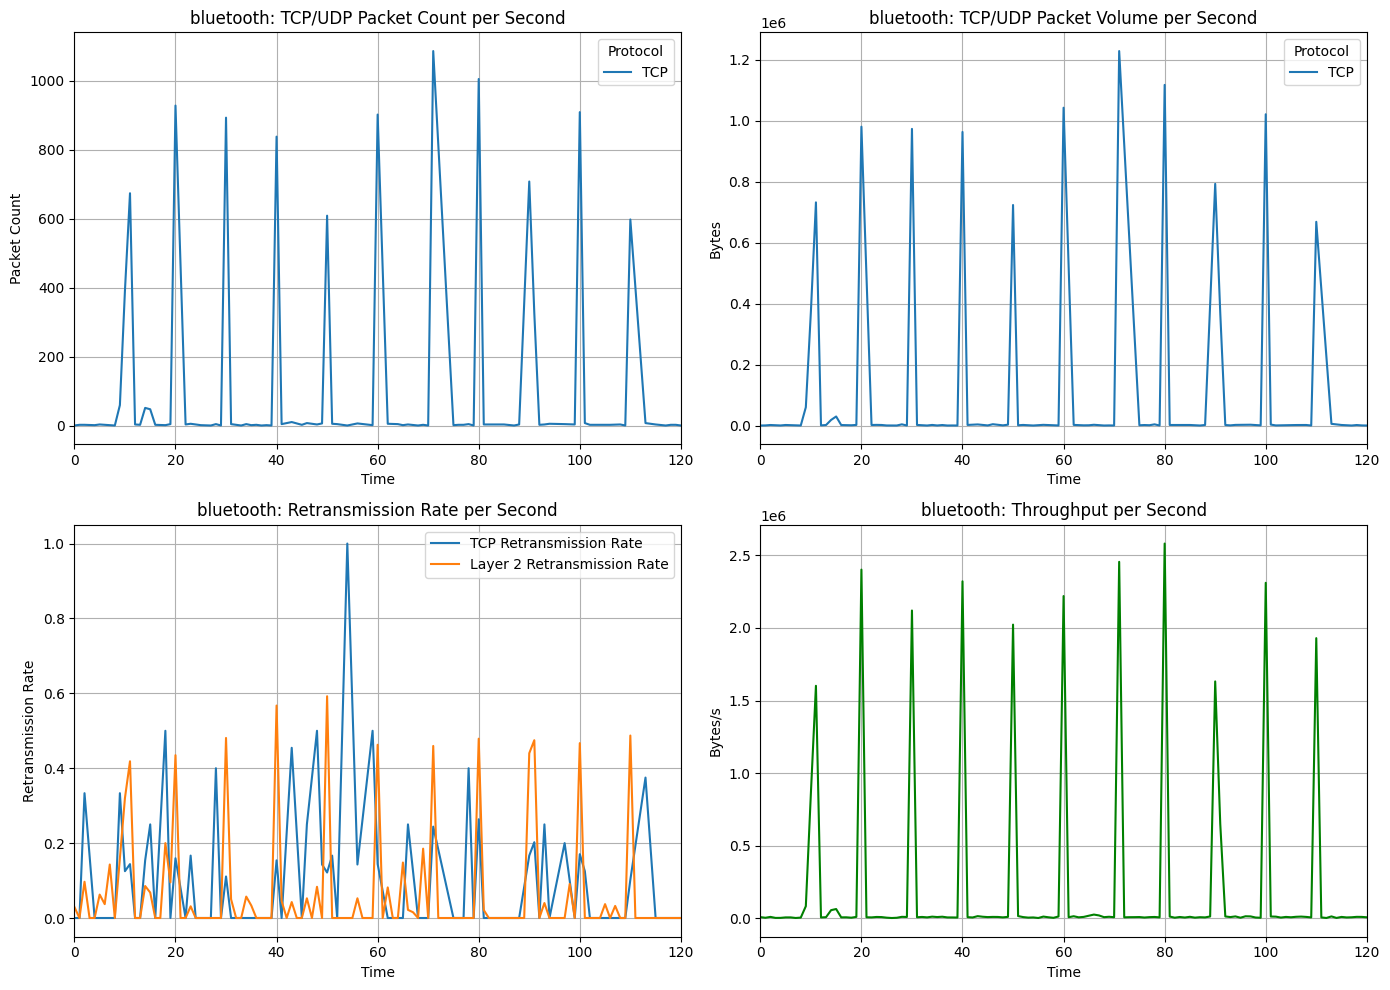

In [ ]:
#4.15
#Bluetooth: 44s

import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('bluetooth.csv')
tcp_retrans = pd.read_csv('bluetooth_tcp_retrans.csv')
layer2_retrans = pd.read_csv('bluetooth_layer2_retrans.csv')

# 预处理时间字段
for df in [data, tcp_retrans, layer2_retrans]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)

# =========================
# 1. TCP & UDP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP', 'UDP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
# TCP
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / tcp_all_count.replace(0, pd.NA)).fillna(0)

# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == '802.11'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / layer2_all_count.replace(0, pd.NA)).fillna(0)

# =========================
# 3. Throughput (all traffic)
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()

# =========================
# 4. 只保留31s到151s的数据，并重设x轴从0开始
# =========================
start, end = 44, 164
# 只取时间范围内的数据
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]

# 把时间bin映射成0~120
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start

# =========================
# 5. 绘图
# =========================
plt.figure(figsize=(14, 10))

# TCP/UDP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('bluetooth: TCP/UDP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
packet_volumes.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('bluetooth: TCP/UDP Packet Volume per Second')
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('bluetooth: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Throughput
plt.subplot(2, 2, 4)
plt.plot(throughput.index, throughput.values, color='green')
plt.xlabel('Time')
plt.ylabel('Bytes/s')
plt.title('bluetooth: Throughput per Second')
plt.grid(True)
plt.xlim(0, end - start)

plt.tight_layout()
plt.show()


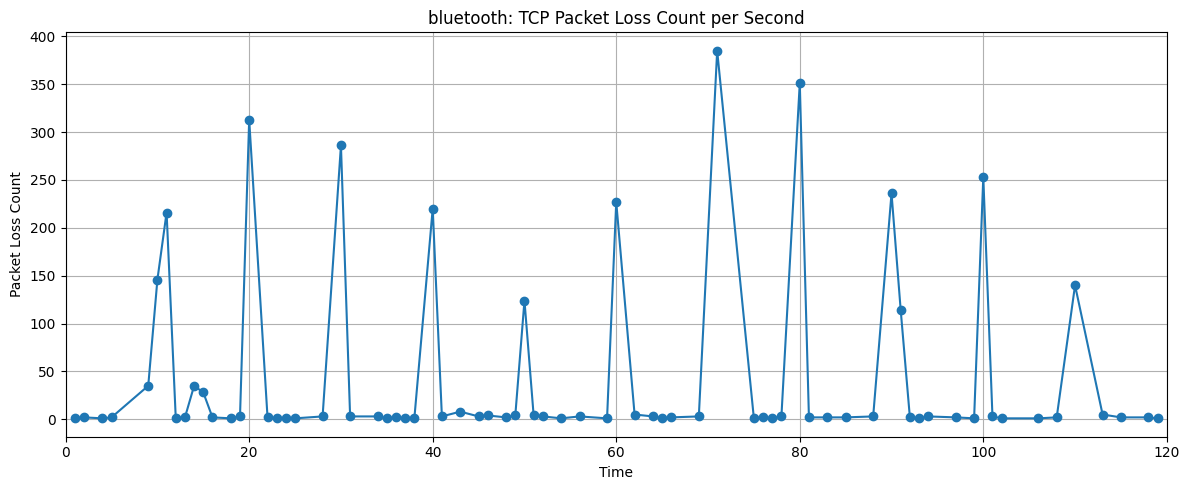

Total inferred TCP packet loss count: 3235


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# 读取CSV
df = pd.read_csv('bluetooth.csv')  # 修改成你的实际CSV文件名

# 提取 TCP Seq
def extract_seq(info):
    match = re.search(r'Seq=(\d+)', str(info))
    return int(match.group(1)) if match else None

# 预处理
df['Seq'] = df['Info'].apply(extract_seq)
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df.dropna(subset=['Seq', 'Time'], inplace=True)

# 保证只分析TCP包（如果有Protocol列）
if 'Protocol' in df.columns:
    df = df[df['Protocol'] == 'TCP']

# 按 Seq 升序 + Time 升序排序
df.sort_values(by=['Seq', 'Time'], inplace=True)

# 给每个 packet 添加发送次数编号（第一次发送是0，第二次发送是1，依此类推）
df['Seq_Send_Count'] = df.groupby('Seq').cumcount()

# 只保留 retransmission 包（即发送次数编号 > 0）
retransmissions = df[df['Seq_Send_Count'] > 0].copy()

# 把 retransmission 按 timestamp 秒数分组
retransmissions['Time_sec'] = retransmissions['Time'].astype(int)

# 只保留 31s 到 151s 的丢包数据
start, end = 44, 164
retransmissions = retransmissions[(retransmissions['Time_sec'] >= start) & (retransmissions['Time_sec'] <= end)]

# 重新映射时间：让31秒变成0秒
retransmissions['Time_mapped'] = retransmissions['Time_sec'] - start

# 每秒丢包数量
packet_loss_per_sec = retransmissions.groupby('Time_mapped').size()

# =========================
# 绘制每秒丢包数量
# =========================
plt.figure(figsize=(12, 5))
plt.plot(packet_loss_per_sec.index, packet_loss_per_sec.values, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Packet Loss Count')
plt.title('bluetooth: TCP Packet Loss Count per Second')
plt.grid(True)
plt.xlim(0, end - start)
plt.tight_layout()
plt.show()

# =========================
# 打印总丢包数（在31~151s范围内）
# =========================
total_packet_loss = len(retransmissions)
print("Total inferred TCP packet loss count:", total_packet_loss)


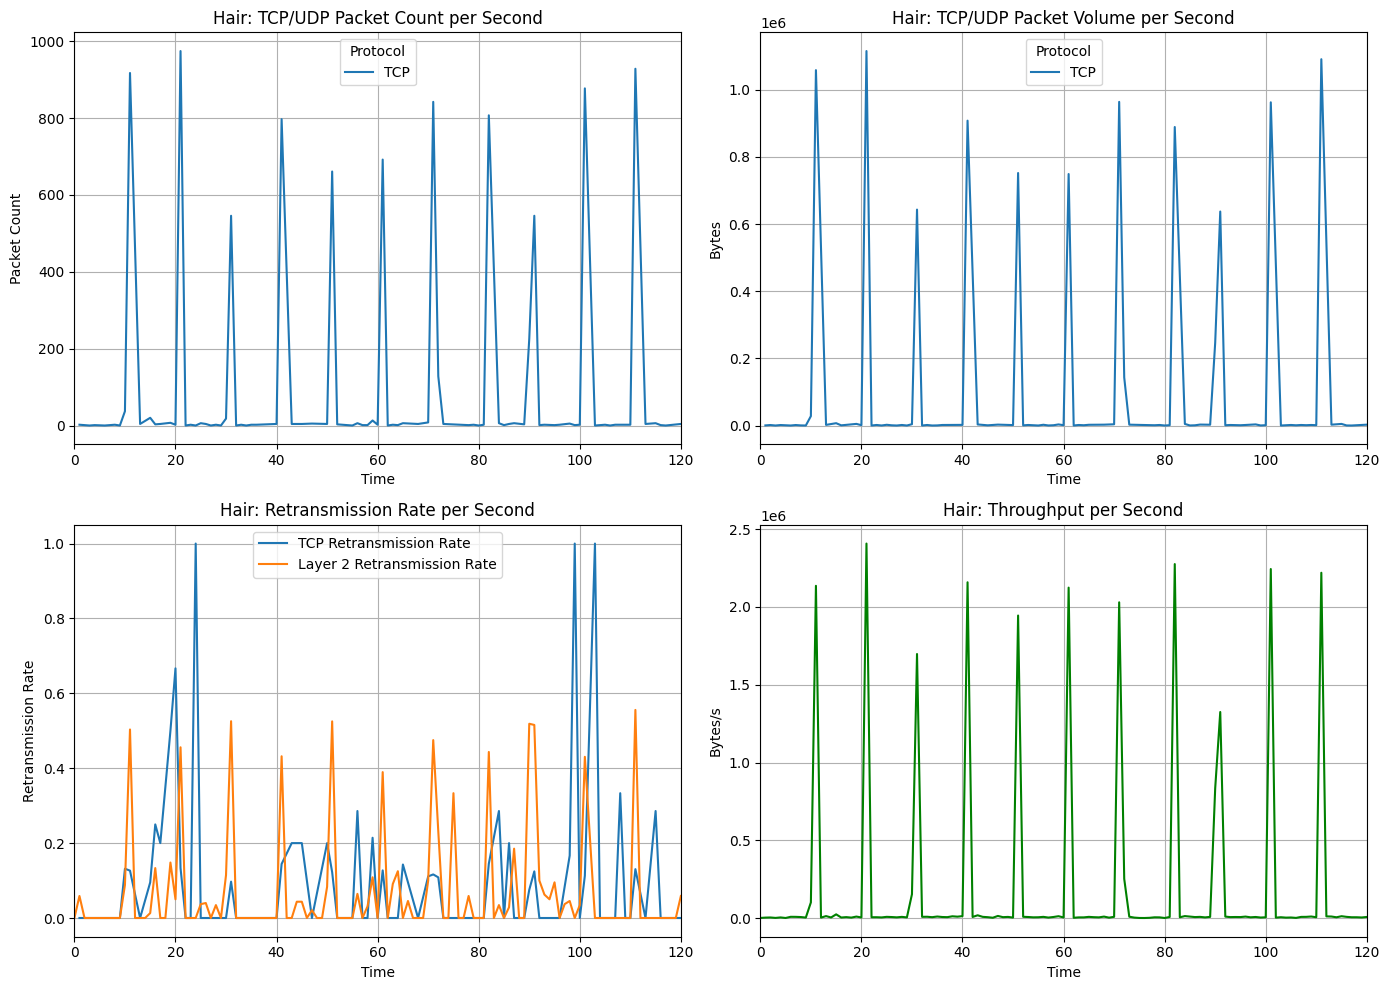

In [ ]:
#4.15
#Hair: 35s

import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('Hair.csv')
tcp_retrans = pd.read_csv('Hair_tcp_retrans.csv')
layer2_retrans = pd.read_csv('Hair_layer2_retrans.csv')

# 预处理时间字段
for df in [data, tcp_retrans, layer2_retrans]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)

# =========================
# 1. TCP & UDP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP', 'UDP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
# TCP
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / tcp_all_count.replace(0, pd.NA)).fillna(0)

# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == '802.11'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / layer2_all_count.replace(0, pd.NA)).fillna(0)

# =========================
# 3. Throughput (all traffic)
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()

# =========================
# 4. 只保留31s到151s的数据，并重设x轴从0开始
# =========================
start, end = 35, 155
# 只取时间范围内的数据
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]

# 把时间bin映射成0~120
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start

# =========================
# 5. 绘图
# =========================
plt.figure(figsize=(14, 10))

# TCP/UDP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('Hair: TCP/UDP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
packet_volumes.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('Hair: TCP/UDP Packet Volume per Second')
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('Hair: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Throughput
plt.subplot(2, 2, 4)
plt.plot(throughput.index, throughput.values, color='green')
plt.xlabel('Time')
plt.ylabel('Bytes/s')
plt.title('Hair: Throughput per Second')
plt.grid(True)
plt.xlim(0, end - start)

plt.tight_layout()
plt.show()


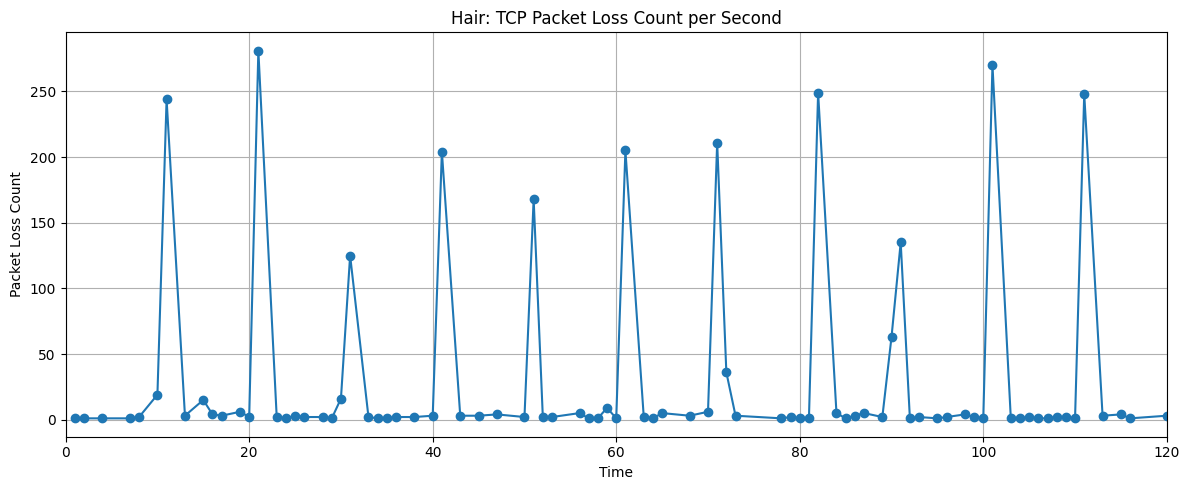

Total inferred TCP packet loss count: 2644


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# 读取CSV
df = pd.read_csv('Hair.csv')  # 修改成你的实际CSV文件名

# 提取 TCP Seq
def extract_seq(info):
    match = re.search(r'Seq=(\d+)', str(info))
    return int(match.group(1)) if match else None

# 预处理
df['Seq'] = df['Info'].apply(extract_seq)
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df.dropna(subset=['Seq', 'Time'], inplace=True)

# 保证只分析TCP包（如果有Protocol列）
if 'Protocol' in df.columns:
    df = df[df['Protocol'] == 'TCP']

# 按 Seq 升序 + Time 升序排序
df.sort_values(by=['Seq', 'Time'], inplace=True)

# 给每个 packet 添加发送次数编号（第一次发送是0，第二次发送是1，依此类推）
df['Seq_Send_Count'] = df.groupby('Seq').cumcount()

# 只保留 retransmission 包（即发送次数编号 > 0）
retransmissions = df[df['Seq_Send_Count'] > 0].copy()

# 把 retransmission 按 timestamp 秒数分组
retransmissions['Time_sec'] = retransmissions['Time'].astype(int)

# 只保留 31s 到 151s 的丢包数据
start, end = 35, 155
retransmissions = retransmissions[(retransmissions['Time_sec'] >= start) & (retransmissions['Time_sec'] <= end)]

# 重新映射时间：让31秒变成0秒
retransmissions['Time_mapped'] = retransmissions['Time_sec'] - start

# 每秒丢包数量
packet_loss_per_sec = retransmissions.groupby('Time_mapped').size()

# =========================
# 绘制每秒丢包数量
# =========================
plt.figure(figsize=(12, 5))
plt.plot(packet_loss_per_sec.index, packet_loss_per_sec.values, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Packet Loss Count')
plt.title('Hair: TCP Packet Loss Count per Second')
plt.grid(True)
plt.xlim(0, end - start)
plt.tight_layout()
plt.show()

# =========================
# 打印总丢包数（在31~151s范围内）
# =========================
total_packet_loss = len(retransmissions)
print("Total inferred TCP packet loss count:", total_packet_loss)


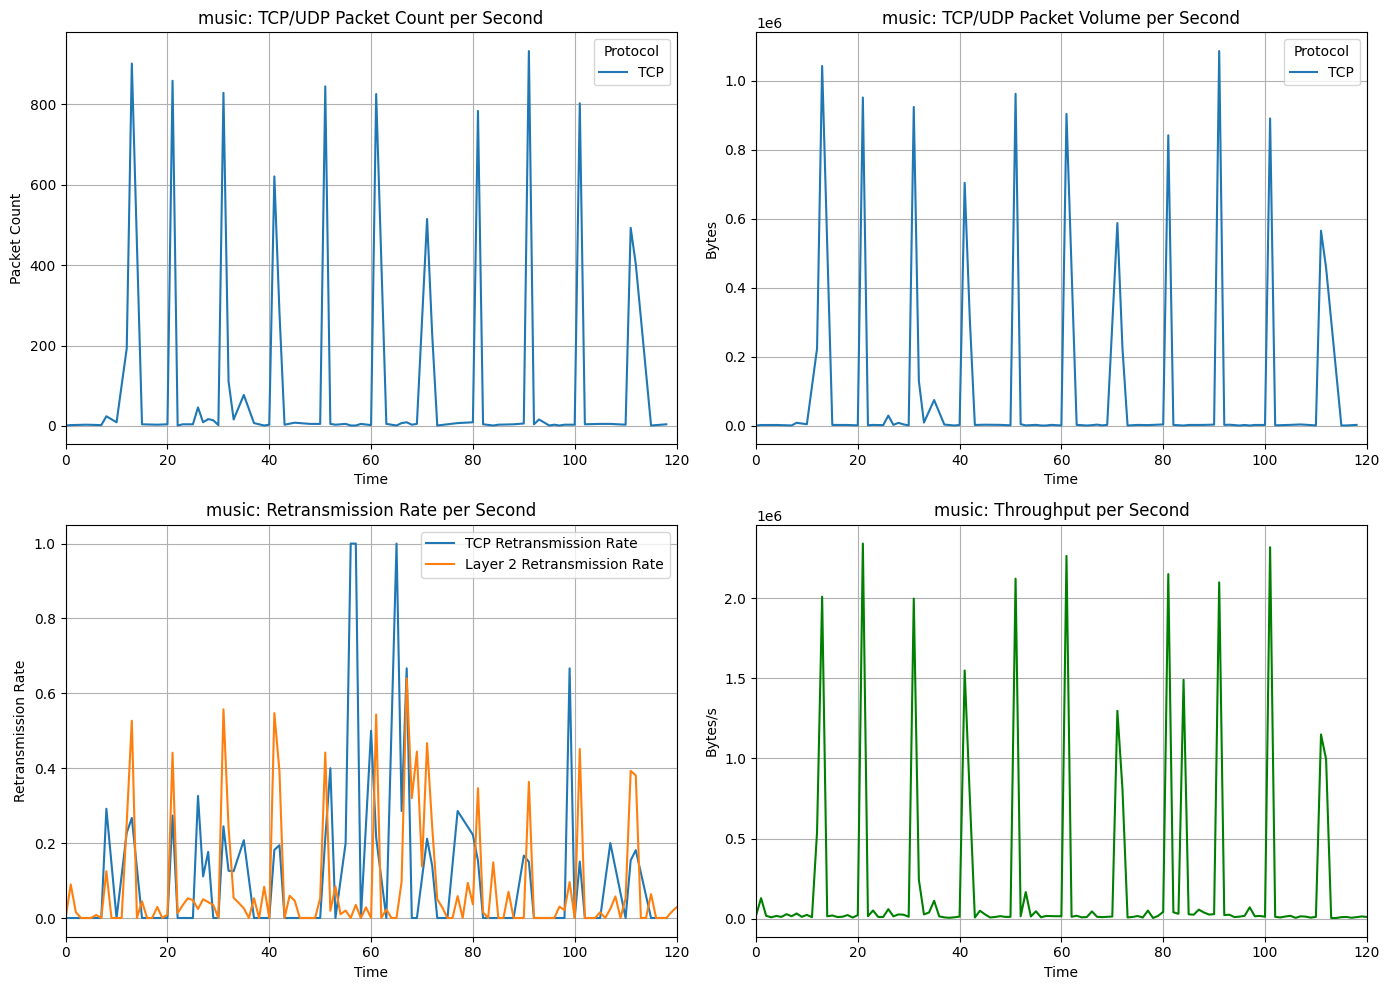

In [ ]:
#4.15
#music: 26s

import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('music.csv')
tcp_retrans = pd.read_csv('music_tcp_retrans.csv')
layer2_retrans = pd.read_csv('music_layer2_retrans.csv')

# 预处理时间字段
for df in [data, tcp_retrans, layer2_retrans]:
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df['Time_bin'] = df['Time'].astype(int)

# =========================
# 1. TCP & UDP Packet Count & Volume
# =========================
tcp_udp = data[data['Protocol'].isin(['TCP', 'UDP'])]

packet_counts = tcp_udp.groupby(['Time_bin', 'Protocol']).size().unstack(fill_value=0)
packet_volumes = tcp_udp.groupby(['Time_bin', 'Protocol'])['Length'].sum().unstack(fill_value=0)

# =========================
# 2. Retransmission Rates
# =========================
# TCP
tcp_retrans_count = tcp_retrans.groupby('Time_bin').size()
tcp_all_count = data[data['Protocol'] == 'TCP'].groupby('Time_bin').size()
tcp_retrans_rate = (tcp_retrans_count / tcp_all_count.replace(0, pd.NA)).fillna(0)

# Layer 2
layer2_retrans_count = layer2_retrans.groupby('Time_bin').size()
layer2_all_count = data[data['Protocol'] == '802.11'].groupby('Time_bin').size()
layer2_retrans_rate = (layer2_retrans_count / layer2_all_count.replace(0, pd.NA)).fillna(0)

# =========================
# 3. Throughput (all traffic)
# =========================
throughput = data.groupby('Time_bin')['Length'].sum()

# =========================
# 4. 只保留31s到151s的数据，并重设x轴从0开始
# =========================
start, end = 26, 146
# 只取时间范围内的数据
packet_counts = packet_counts.loc[start:end]
packet_volumes = packet_volumes.loc[start:end]
tcp_retrans_rate = tcp_retrans_rate.loc[start:end]
layer2_retrans_rate = layer2_retrans_rate.loc[start:end]
throughput = throughput.loc[start:end]

# 把时间bin映射成0~120
packet_counts.index = packet_counts.index - start
packet_volumes.index = packet_volumes.index - start
tcp_retrans_rate.index = tcp_retrans_rate.index - start
layer2_retrans_rate.index = layer2_retrans_rate.index - start
throughput.index = throughput.index - start

# =========================
# 5. 绘图
# =========================
plt.figure(figsize=(14, 10))

# TCP/UDP Packet Counts
plt.subplot(2, 2, 1)
packet_counts.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.title('music: TCP/UDP Packet Count per Second')
plt.grid(True)
plt.xlim(0, end - start)

# TCP/UDP Packet Volumes
plt.subplot(2, 2, 2)
packet_volumes.plot(ax=plt.gca())
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('music: TCP/UDP Packet Volume per Second')
plt.grid(True)
plt.xlim(0, end - start)

# Retransmission Rate Plot
plt.subplot(2, 2, 3)
plt.plot(tcp_retrans_rate.index, tcp_retrans_rate.values, label='TCP Retransmission Rate')
plt.plot(layer2_retrans_rate.index, layer2_retrans_rate.values, label='Layer 2 Retransmission Rate')
plt.xlabel('Time')
plt.ylabel('Retransmission Rate')
plt.title('music: Retransmission Rate per Second')
plt.legend()
plt.grid(True)
plt.xlim(0, end - start)

# Throughput
plt.subplot(2, 2, 4)
plt.plot(throughput.index, throughput.values, color='green')
plt.xlabel('Time')
plt.ylabel('Bytes/s')
plt.title('music: Throughput per Second')
plt.grid(True)
plt.xlim(0, end - start)

plt.tight_layout()
plt.show()


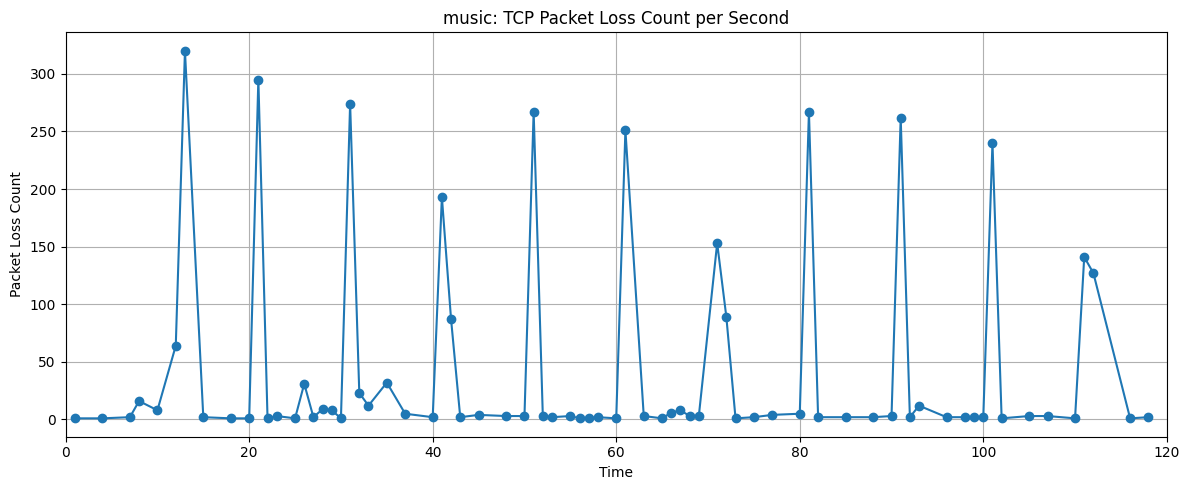

Total inferred TCP packet loss count: 3295


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# 读取CSV
df = pd.read_csv('music.csv')  # 修改成你的实际CSV文件名

# 提取 TCP Seq
def extract_seq(info):
    match = re.search(r'Seq=(\d+)', str(info))
    return int(match.group(1)) if match else None

# 预处理
df['Seq'] = df['Info'].apply(extract_seq)
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df.dropna(subset=['Seq', 'Time'], inplace=True)

# 保证只分析TCP包（如果有Protocol列）
if 'Protocol' in df.columns:
    df = df[df['Protocol'] == 'TCP']

# 按 Seq 升序 + Time 升序排序
df.sort_values(by=['Seq', 'Time'], inplace=True)

# 给每个 packet 添加发送次数编号（第一次发送是0，第二次发送是1，依此类推）
df['Seq_Send_Count'] = df.groupby('Seq').cumcount()

# 只保留 retransmission 包（即发送次数编号 > 0）
retransmissions = df[df['Seq_Send_Count'] > 0].copy()

# 把 retransmission 按 timestamp 秒数分组
retransmissions['Time_sec'] = retransmissions['Time'].astype(int)

# 只保留 31s 到 151s 的丢包数据
start, end = 26, 146
retransmissions = retransmissions[(retransmissions['Time_sec'] >= start) & (retransmissions['Time_sec'] <= end)]

# 重新映射时间：让31秒变成0秒
retransmissions['Time_mapped'] = retransmissions['Time_sec'] - start

# 每秒丢包数量
packet_loss_per_sec = retransmissions.groupby('Time_mapped').size()

# =========================
# 绘制每秒丢包数量
# =========================
plt.figure(figsize=(12, 5))
plt.plot(packet_loss_per_sec.index, packet_loss_per_sec.values, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Packet Loss Count')
plt.title('music: TCP Packet Loss Count per Second')
plt.grid(True)
plt.xlim(0, end - start)
plt.tight_layout()
plt.show()

# =========================
# 打印总丢包数（在31~151s范围内）
# =========================
total_packet_loss = len(retransmissions)
print("Total inferred TCP packet loss count:", total_packet_loss)
